In [94]:
import os
import torch
import sys
import torchvision
import yaml
from yolov5.train import main as train_yolo
from yolov5.val import main as val_yolo
from yolov5.detect import main as detect_yolo
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet18
from torchvision.ops import MultiScaleRoIAlign
from PIL import Image
import numpy as np
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Adil\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [19]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    # if len(img_1.shape) == 3 or len(img_2.shape) == 3:
    #     img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    #     img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

In [5]:
class YOLODataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.images = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))

        # Load image
        img = Image.open(img_path).convert("RGB")
        width, height = img.size

        # Load labels
        boxes = []
        labels = []
        with open(label_path) as f:
            for line in f.readlines():
                class_id, xc, yc, w, h = map(float, line.strip().split())
                xmin = (xc - w / 2) * width
                ymin = (yc - h / 2) * height
                xmax = (xc + w / 2) * width
                ymax = (yc + h / 2) * height
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(class_id))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


transform = ToTensor()

train_dataset = YOLODataset("dataset/images/train", "dataset/labels/train", transform)
val_dataset = YOLODataset("dataset/images/val", "dataset/labels/val", transform)
test_dataset = YOLODataset("dataset/images/test", "dataset/labels/test", transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    train_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    model.to(device)

    for epoch in range(num_epochs):
        epoch_train_loss = 0
        model.train()

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_train_loss += losses.item()

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- Validation ---
        epoch_val_loss = 0
        # Force model to return losses during validation
        model.train()
        with torch.no_grad():
            for images, targets in val_loader:
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                epoch_val_loss += losses.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)

        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pth")

    # Load best model weights before returning
    model.load_state_dict(torch.load("best_model.pth"))
    return model, train_losses, validation_losses



In [12]:
backbone = resnet18(weights=None)
backbone = nn.Sequential(*list(backbone.children())[:-2])
backbone.out_channels = 512

anchor_gen = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)

roi_pooler = MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

model = FasterRCNN(
    backbone=backbone,
    num_classes=3,  # Camera + Headphones + background
    rpn_anchor_generator=anchor_gen,
    box_roi_pool=roi_pooler
)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

model, train_loss_no_weights, val_loss_no_weights = train_model(model, train_loader, val_loader, optimizer, num_epochs=10)

[Epoch 1/10] Train Loss: 0.1836 | Val Loss: 0.1062
[Epoch 2/10] Train Loss: 0.0899 | Val Loss: 0.0852
[Epoch 3/10] Train Loss: 0.0653 | Val Loss: 0.0560
[Epoch 4/10] Train Loss: 0.0524 | Val Loss: 0.0458
[Epoch 5/10] Train Loss: 0.0399 | Val Loss: 0.0379
[Epoch 6/10] Train Loss: 0.0369 | Val Loss: 0.0359
[Epoch 7/10] Train Loss: 0.0306 | Val Loss: 0.0285
[Epoch 8/10] Train Loss: 0.0271 | Val Loss: 0.0265
[Epoch 9/10] Train Loss: 0.0245 | Val Loss: 0.0303
[Epoch 10/10] Train Loss: 0.0214 | Val Loss: 0.0292


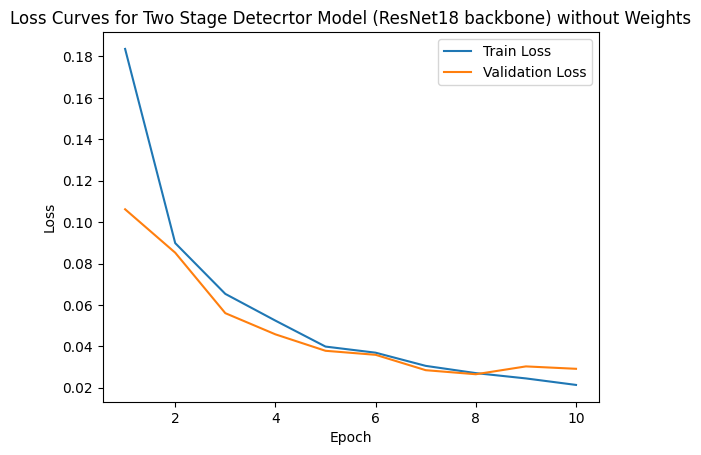

In [84]:
epochs = range(1, 11)
plt.plot(epochs, train_loss_no_weights, label='Train Loss')
plt.plot(epochs, val_loss_no_weights, label='Validation Loss')
plt.title('Loss Curves for Two Stage Detecrtor Model (ResNet18 backbone) without Weights')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


We can observe that model starts overfitting after epoch 8. In other words, training loss decreases, but validation loss started to increase

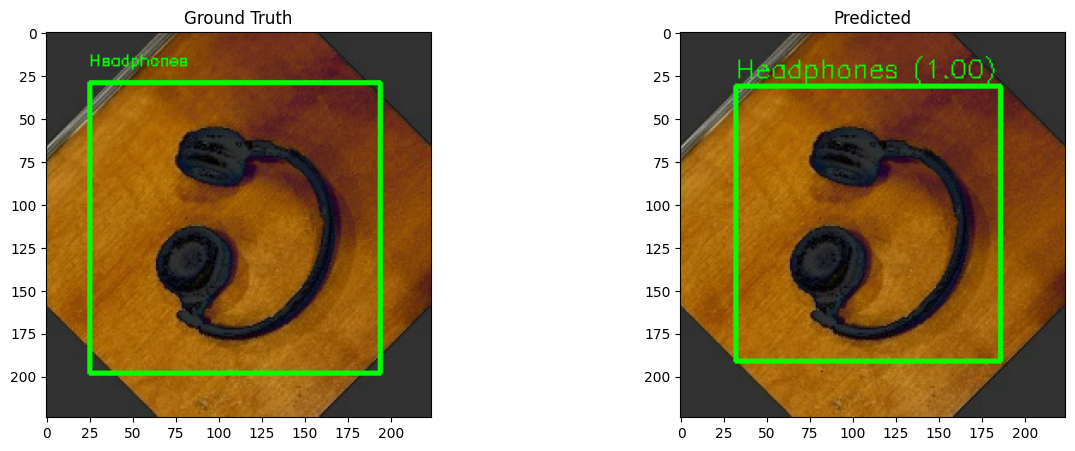

In [21]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = ToTensor()
    return transform(image), image


def visualize_prediction(model_, image_path, classes, threshold=0.5):
    model_.eval()
    image_tensor, orig_image = load_image(image_path)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        prediction = model_([image_tensor])[0]

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()

    # Draw boxes
    img = cv2.cvtColor(np.array(orig_image), cv2.COLOR_RGB2BGR)

    for box, score, label in zip(boxes, scores, labels):
        if score < threshold:
            continue
        x1, y1, x2, y2 = box.astype(int)
        class_name = classes[label]

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{class_name} ({score:.2f})", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img


def visualize_bounding_box(image_path, label_file, classes):

    image = cv2.imread(image_path)

    # Read the bounding box information
    with open(label_file, "r") as file:
        lines = file.readlines()

    class_id, x_center, y_center, width_norm, height_norm = map(float, lines[0].split())

    # Calculate the bounding box coordinates
    image_width, image_height = image.shape[1], image.shape[0]
    x_min = int((x_center - width_norm / 2) * image_width)
    y_min = int((y_center - height_norm / 2) * image_height)
    width = int(width_norm * image_width)
    height = int(height_norm * image_height)

    # Draw the bounding box rectangle
    cv2.rectangle(image, (x_min, y_min), (x_min + width, y_min + height), (0, 255, 0), 2)

    # Label the image
    label = f"{classes[int(class_id)]}"
    cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

    # Convert BGR image to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image_rgb, label, (x_min, y_min, width, height)


classes = {0: "Camera", 1: "Headphones"}

img_path = "dataset/images/test/image_12.jpg"
label_path = "dataset/labels/test/image_12.txt"

img_truth, label, bbox = visualize_bounding_box(img_path, label_path, classes)
img_pred = visualize_prediction(model, img_path, classes)

plot_side_by_side(img_truth, img_pred, title1="Ground Truth", title2="Predicted")


In [53]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(images)):
            pred_boxes = outputs[i]['boxes'].cpu().numpy()
            pred_labels = outputs[i]['labels'].cpu().numpy()
            pred_scores = outputs[i]['scores'].cpu().numpy()

            true_boxes = targets[i]['boxes'].cpu().numpy()
            true_labels = targets[i]['labels'].cpu().numpy()

            all_preds.append({
                "boxes": pred_boxes,
                "labels": pred_labels,
                "scores": pred_scores
            })
            all_targets.append({
                "boxes": true_boxes,
                "labels": true_labels
            })


100%|██████████| 102/102 [00:11<00:00,  8.54it/s]


In [66]:
metric = MeanAveragePrecision()

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        # move everything to CPU and format as required
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]
        targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

        metric.update(outputs, targets)

results = metric.compute()
print("mAP for Unweighted Two stage Detector Model: ", results['map'].item())


mAP for Unweighted Two stage Detector Model:  0.42022058367729187


In [81]:
y_true = []
y_pred = []

print("Calculating metrics for Unweighted Two stage Detector Model...")

for preds, targets in zip(all_preds, all_targets):
    if len(preds['labels']) == 0:
        y_pred.append(2)
        y_true.append(targets['labels'][0])

    elif len(preds['labels']) > 0:
        y_pred.append(preds['labels'][0])
        y_true.extend(targets['labels'])

    else:
        y_pred.extend(preds['labels'])
        y_true.extend(targets['labels'])

print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1-score:", f1_score(y_true, y_pred, average='weighted'))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Camera", "Headphones", "Background"]))


Calculating metrics for Unweighted Two stage Detector Model...
Precision: 0.3653161380786333
Recall: 0.49014778325123154
F1-score: 0.41862407239053684
Confusion Matrix:
[[  0  68 139]
 [  0 199   0]
 [  0   0   0]]
Classification Report:
              precision    recall  f1-score   support

      Camera       0.00      0.00      0.00       207
  Headphones       0.75      1.00      0.85       199
  Background       0.00      0.00      0.00         0

    accuracy                           0.49       406
   macro avg       0.25      0.33      0.28       406
weighted avg       0.37      0.49      0.42       406



C:\Users\Adil\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Adil\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Adil\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

In [73]:
backbone_weights = resnet18(weights="DEFAULT")
backbone_weights = nn.Sequential(*list(backbone_weights.children())[:-2])
backbone_weights.out_channels = 512
model_weights = FasterRCNN(
    backbone=backbone_weights,
    num_classes=3,
    rpn_anchor_generator=anchor_gen,
    box_roi_pool=roi_pooler
)

model_weights.to(device)

optimizer_2 = torch.optim.Adam(model_weights.parameters(), lr=1e-4, weight_decay=1e-5)

model_weights, train_loss_weights, val_loss_weights = train_model(model_weights, train_loader, val_loader, optimizer_2, num_epochs=15)

[Epoch 1/15] Train Loss: 0.1279 | Val Loss: 0.0629
[Epoch 2/15] Train Loss: 0.0529 | Val Loss: 0.0449
[Epoch 3/15] Train Loss: 0.0382 | Val Loss: 0.0321
[Epoch 4/15] Train Loss: 0.0319 | Val Loss: 0.0287
[Epoch 5/15] Train Loss: 0.0263 | Val Loss: 0.0285
[Epoch 6/15] Train Loss: 0.0215 | Val Loss: 0.0223
[Epoch 7/15] Train Loss: 0.0183 | Val Loss: 0.0231
[Epoch 8/15] Train Loss: 0.0172 | Val Loss: 0.0159
[Epoch 9/15] Train Loss: 0.0152 | Val Loss: 0.0153
[Epoch 10/15] Train Loss: 0.0128 | Val Loss: 0.0144
[Epoch 11/15] Train Loss: 0.0133 | Val Loss: 0.0147
[Epoch 12/15] Train Loss: 0.0124 | Val Loss: 0.0183
[Epoch 13/15] Train Loss: 0.0138 | Val Loss: 0.0167
[Epoch 14/15] Train Loss: 0.0118 | Val Loss: 0.0145
[Epoch 15/15] Train Loss: 0.0115 | Val Loss: 0.0129


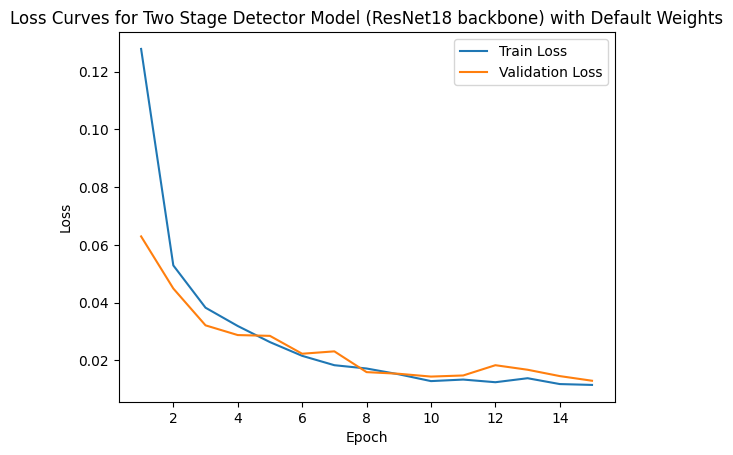

In [85]:
epochs = range(1, 16)

plt.plot(epochs, train_loss_weights, label='Train Loss')
plt.plot(epochs, val_loss_weights, label='Validation Loss')
plt.title('Loss Curves for Two Stage Detector Model (ResNet18 backbone) with Default Weights')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can see that the model is not overfit yet, so we can train it longer. Unfortunately I am running out of time, so i will be using a model after 15 epochs

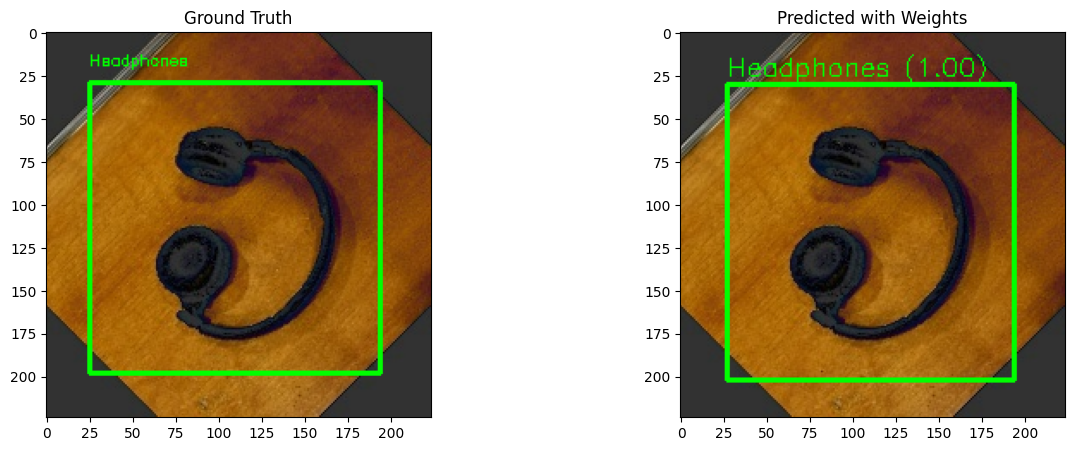

In [86]:
img_pred_weights = visualize_prediction(model_weights, img_path, classes)

plot_side_by_side(img_truth, img_pred_weights, title1="Ground Truth", title2="Predicted with Weights")

We can see that the PRETRAINED model is more accurate    

In [89]:
all_preds_weights = []
all_targets_weights = []

model_weights.eval()
with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = [img.to(device) for img in images]
        outputs = model_weights(images)

        for i in range(len(images)):
            pred_boxes = outputs[i]['boxes'].cpu().numpy()
            pred_labels = outputs[i]['labels'].cpu().numpy()
            pred_scores = outputs[i]['scores'].cpu().numpy()

            true_boxes = targets[i]['boxes'].cpu().numpy()
            true_labels = targets[i]['labels'].cpu().numpy()

            all_preds_weights.append({
                "boxes": pred_boxes,
                "labels": pred_labels,
                "scores": pred_scores
            })
            all_targets_weights.append({
                "boxes": true_boxes,
                "labels": true_labels
            })

100%|██████████| 102/102 [00:22<00:00,  4.62it/s]


In [90]:
metric_weights = MeanAveragePrecision()

model_weights.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model_weights(images)

        # move everything to CPU and format as required
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]
        targets = [{k: v.cpu() for k, v in t.items()} for t in targets]

        metric_weights.update(outputs, targets)

results = metric_weights.compute()
print("mAP for Weighted Two stage Detector Model: ", results['map'].item())

mAP for Weighted Two stage Detector Model:  0.46177515387535095


In [91]:
y_true_weights = []
y_pred_weights = []

print("Calculating metrics for Unweighted Two stage Detector Model...")

for preds, targets in zip(all_preds_weights, all_targets_weights):
    if len(preds['labels']) == 0:
        y_pred_weights.append(2)
        y_true_weights.append(targets['labels'][0])

    elif len(preds['labels']) > 0:
        y_pred_weights.append(preds['labels'][0])
        y_true_weights.extend(targets['labels'])

    else:
        y_pred_weights.extend(preds['labels'])
        y_true_weights.extend(targets['labels'])

print("Precision:", precision_score(y_true_weights, y_pred_weights, average='weighted'))
print("Recall:", recall_score(y_true_weights, y_pred_weights, average='weighted'))
print("F1-score:", f1_score(y_true_weights, y_pred_weights, average='weighted'))
print("Confusion Matrix:")
print(confusion_matrix(y_true_weights, y_pred_weights))
print("Classification Report:")
print(classification_report(y_true_weights, y_pred_weights, target_names=["Camera", "Headphones", "Background"]))


Calculating metrics for Unweighted Two stage Detector Model...
Precision: 0.4413547912533714
Recall: 0.49014778325123154
F1-score: 0.4644733755571194
Confusion Matrix:
[[  0  22 185]
 [  0 199   0]
 [  0   0   0]]
Classification Report:
              precision    recall  f1-score   support

      Camera       0.00      0.00      0.00       207
  Headphones       0.90      1.00      0.95       199
  Background       0.00      0.00      0.00         0

    accuracy                           0.49       406
   macro avg       0.30      0.33      0.32       406
weighted avg       0.44      0.49      0.46       406



C:\Users\Adil\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Adil\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Adil\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result